[' ', '!', "'", ',', '.', '0', '2', '?', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['\t', '\n', ' ', '!', '(', ')', ',', '.', '0', '2', '?', 'C', 'D', 'அ', 'ஆ', 'இ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஒ', 'ஓ', 'க', 'ங', 'ச', 'ஜ', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ஷ', 'ஸ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', '்']
Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, None, 53)]   0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, None, 5

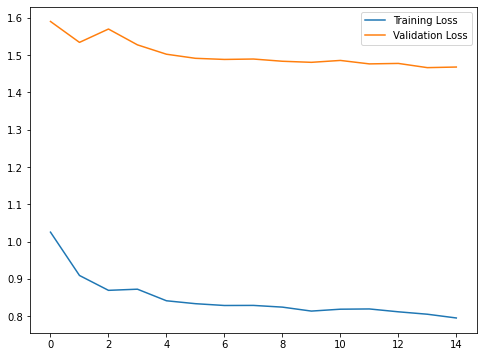

-
Input sentence: I slept.
Decoded sentence: அவன் க் க்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்


In [ ]:
import sys
import os
sys.path.append("/Users/jayanti/opt/anaconda3/envs/transformers_env/lib/python3.9/site-packages")
#Importing library
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import *
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


import tensorflow as tf
import time, random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,  TensorBoard
   

def get_data (num_samples):

    #with open('/Users/jayanti/Data/Seq2Seq/fra.txt', 'r', encoding='utf-8') as f:
    #    lines = f.read().split('\n')
    
    
    with open('/Users/jayanti/Data/Seq2Seq/tam.txt', 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    
    input_chars = set()
    target_chars = set()
    input_texts = []
    target_texts = []
    
    
    for line in lines[: min(num_samples, len(lines) - 1)]:
        input_text, target_text, extra = line.split('\t')
        target_text = '\t' + target_text + '\n'
        input_texts.append(input_text)
        target_texts.append(target_text)
        
        for char in input_text:
            if char not in input_chars:
                input_chars.add(char)
        for char in target_text:
            if char not in target_chars:
                target_chars.add(char)

            
    input_chars = sorted(list(input_chars))
    target_chars = sorted(list(target_chars))
    

    num_encoder_tokens = len(input_chars)
    num_decoder_tokens = len(target_chars)
    max_encoder_seq_len = max([len(txt) for txt in input_texts])
    max_decoder_seq_len = max([len(txt) for txt in target_texts])

    P = {'num_encoder_tokens': num_encoder_tokens, 
        'num_decoder_tokens': num_decoder_tokens,
        'max_encoder_seq_len': max_encoder_seq_len,
        'max_decoder_seq_len': max_decoder_seq_len,
        'input_chars': input_chars,
        'target_chars': target_chars}
 

    #Define data for encoder and decoder
    input_token_id = dict([(char, i) for i, char in enumerate(input_chars)])
    target_token_id = dict([(char, i) for i, char in enumerate(target_chars)])

    return P, input_token_id, target_token_id, input_texts, target_texts  


def data_vectorize (P, input_texts, target_texst, input_token_id, target_token_id):
    
    num_encoder_tokens = P['num_encoder_tokens']
    num_decoder_tokens = P['num_decoder_tokens']
    
    max_encoder_seq_len = P['max_encoder_seq_len']
    max_decoder_seq_len = P['max_decoder_seq_len']
    input_chars = P['input_chars']
    target_chars = P['target_chars']
 
    encoder_in_data = np.zeros((len(input_texts), max_encoder_seq_len, num_encoder_tokens), dtype='float32')
    decoder_in_data = np.zeros((len(input_texts), max_decoder_seq_len, num_decoder_tokens), dtype='float32')
    decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_len, num_decoder_tokens), dtype='float32')


    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_in_data[i, t, input_token_id[char]] = 1.
   
        for t, char in enumerate(target_text):
             decoder_in_data[i, t, target_token_id[char]] = 1.
             if t > 0:
                decoder_target_data[i, t - 1, target_token_id[char]] = 1.

    return encoder_in_data, decoder_in_data,  decoder_target_data



class Seq2Seq_Model:
    def __init__(self, workspace, num_encoder_tokens, num_decoder_tokens, latent_dim):
        
        self.workspace = workspace 
        self.model_dir = self.workspace + os.sep + "trained_model"
        self.log_dir = self.workspace + os.sep + "log"
        
        os.makedirs (self.workspace, exist_ok=True)
        os.makedirs (self.model_dir, exist_ok=True)
        os.makedirs (self.log_dir, exist_ok=True)
        
        #Define and process the input sequence
        encoder_inputs = Input(shape=(None, num_encoder_tokens))
        encoder = LSTM(latent_dim, return_state=True)
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)

        #We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        #Using `encoder_states` set up the decoder as initial state.
        decoder_inputs = Input(shape=(None, num_decoder_tokens))
        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(num_decoder_tokens, activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)

        #Final model
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        #Model Summary
        print(self.model.summary())
        
        
        
        #Define sampling models
        self.encoder_model = Model(encoder_inputs, encoder_states)
        decoder_state_input_h = Input(shape=(latent_dim,))
        decoder_state_input_c = Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

        
        
        
    def fit_model (self, encoder_in_data, decoder_in_data,  decoder_target_data, nepochs):
        batch_size = 64
        
         
        
        chkpt = ModelCheckpoint(filepath = self.model_dir + os.sep +"model.hdf5", 
                                save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
        
        tboard = TensorBoard(log_dir=self.log_dir)
        
        callbacks = [chkpt, tboard]    
            
            
            
        #Compiling and training the model
        self.model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), 
            loss='categorical_crossentropy')
        
        hist = self.model.fit([encoder_in_data, decoder_in_data],
            decoder_target_data, callbacks=callbacks, batch_size = batch_size, epochs=nepochs, validation_split=0.2)

        return hist 
    


        

def decode_sequence(P, M, input_token_id, target_token_id, input_seq):
    
    num_encoder_tokens = P['num_encoder_tokens']
    num_decoder_tokens = P['num_decoder_tokens']
    
    max_encoder_seq_len = P['max_encoder_seq_len']
    max_decoder_seq_len = P['max_decoder_seq_len']
    
    reverse_input_char_index = dict((i, char) for char, i in input_token_id.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_id.items())

    
    #Encode the input as state vectors.
    states_value = M.encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    #Get the first character of target sequence with the start character.
    target_seq[0, 0, target_token_id['\t']] = 1.


    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = M.decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
            len(decoded_sentence) > max_decoder_seq_len):
            stop_condition = True
    
        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence




if __name__ == "__main__":
    
    #Hyperparameters
    batch_size = 64
    latent_dim = 256
    num_samples = 20000


    
    P, input_token_id, target_token_id, input_texts, target_texts = get_data (num_samples)
    
    print(P['input_chars'])
    print(P['target_chars'])
    #sys.exit()
    
    encoder_in_data, decoder_in_data,  decoder_target_data = data_vectorize (P, input_texts, target_texts, input_token_id, target_token_id)
        
        

    M =  Seq2Seq_Model ("tmp_results_hn",P['num_encoder_tokens'], P['num_decoder_tokens'], latent_dim)  

    #Model Summary
    print(M.model.summary())
    
    print("encoder_in_data shape:",encoder_in_data.shape)
    print("decoder_in_data shape:",decoder_in_data.shape)
    print("decoder_target_data shape:",decoder_target_data.shape)

    #Visuaize the model
    plot_model(M.model,show_shapes=True)
    plt.show()
    
    hist = M.fit_model (encoder_in_data, decoder_in_data,  decoder_target_data,15)

    fig, axs = plt.subplots (1,1,figsize=(8,6))
    axs.plot(hist.history['loss'],label='Training Loss')
    axs.plot(hist.history['val_loss'],label='Validation Loss')
    axs.legend()
    plt.show()
    
    

    for seq_index in range(10):
        input_seq = encoder_in_data[seq_index: seq_index + 1]
        decoded_sentence = decode_sequence(P, M, input_token_id, target_token_id,input_seq)
        print('-')
        print('Input sentence:', input_texts[seq_index])
        print('Decoded sentence:', decoded_sentence)
    
    